Welcome to the Team 7 Project One!

We are trying to answer the question: "Does proximity to a metro influence a residence's price in Arlington?"

Methodology:
- We used Arlington Country property tax assessments as a proxy for home price
- We calculated each residence's distance to all 11 metro stations in Arlington, VA
- We used the Google Maps API to geocode the latitude and longitude of each metro and residence
- We used the haversine equation to calculate the absolute distance between the two locations
- We randomly selected 10,000 residences for our final data to reduce the number of API calls we needed to make

Findings: Matt and Aimal ADD THESE
    
!!! Notes to the USER !!!
- The use of the haversine equation requires installing the MPU library
- There are two data calls for the Google Maps API - it is ok to skip these cells and move to the next
    if the associated .csv files are available in your folder

In [1]:
# INSTALL if you dont already have mpu library
# !pip install mpu --user

# Dependencies
import requests
import json
import pandas as pd
import numpy as np
from pprint import pprint
import time
import mpu 

# Google developer API key
from config import gkey

# Read in Arlington County Housing Assessment data
arl_data = pd.read_csv("2018_Arl_Asmt.csv")


print(f'The original data set has {len(arl_data)} addresses.')

The original data set has 37708 addresses.


In [2]:
# Clean arl_data set - remove commercial, assessment changes, public housing, etc. to create shortlist of residences
short_list = arl_data[arl_data["PropertyClassTypeCode"].isin([511,512,513,514,515,611,612,613,616,630])] 
short_list = short_list[short_list['AssessmentChangeReasonTypeDsc'].isin(['01- Annual'])]
short_list.drop(short_list[short_list['CommercialInd'] == True].index, inplace=True)
short_list = short_list[pd.isnull(short_list['TaxExemptionTypeDsc'])]
short_list = short_list[short_list['TotalAssessedAmt'] > 70000]  
short_list['State']='VA'

# Slim down the dataset to required columns
house_list = short_list[["PropertyStreetNbrNameText",
                        "PropertyCityName",
                        "State", 
                        "PropertyZipCode",
                        "TotalAssessedAmt"]]

print(f'The cleaned data set has {len(house_list)} addresses.')

The cleaned data set has 32680 addresses.


In [3]:
house_list.head(2)

,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt
1,3007 N ROCHESTER ST,ARLINGTON,VA,22213,1772500
2,6547 WILLIAMSBURG BLVD,ARLINGTON,VA,22213,773000


In [4]:
# Reduce number of properties in sample to 10,000 to limit API calls
house_list_sorted=house_list.sort_values(['TotalAssessedAmt'], ascending=False)
sample_house_list=house_list_sorted.sample(10000)
sample_house_list.reset_index(drop=True, inplace=True)
sample_house_list.head(2)

,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt
0,5512 WILLIAMSBURG BLVD,ARLINGTON,VA,22207,838200
1,419 N NORWOOD ST,ARLINGTON,VA,22203,881000


In [5]:
### SKIP this cell if you do not want to use google maps API and go to next cell (using existing csv file) ###

# Get the latitude and longitude of each residence
params = {"key": gkey}

try:
    for index, row in sample_house_list[0:10000].iterrows():
        base_url = "https://maps.googleapis.com/maps/api/geocode/json"

        street = row["PropertyStreetNbrNameText"]
        city = row["PropertyCityName"]
        state = row["State"]
        zip = row["PropertyZipCode"]

        params['address'] = f"{street},{city},{state},{zip}"

        houses_lat_lng = json.loads(requests.get(base_url, params=params).content)
        current_lat = houses_lat_lng["results"][0]["geometry"]["location"]["lat"]
        current_lng = houses_lat_lng["results"][0]["geometry"]["location"]["lng"]

        sample_house_list.loc[index, "Lat"] = current_lat
        sample_house_list.loc[index, "Lng"] = current_lng
        
        time.sleep(.02)

except KeyError:
    pass

sample_house_list.to_csv('house_list_latlng.csv')
sample_house_list.head()

,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt,Lat,Lng
0,5512 WILLIAMSBURG BLVD,ARLINGTON,VA,22207,838200,38.906584,-77.147505
1,419 N NORWOOD ST,ARLINGTON,VA,22203,881000,38.876819,-77.102423
2,505 N MANCHESTER ST,ARLINGTON,VA,22203,685000,38.871423,-77.133731
3,4102 11th ST N,ARLINGTON,VA,22201,657500,38.883899,-77.109887
4,3708 5th ST S,ARLINGTON,VA,22204,825000,38.866453,-77.097340


In [6]:
len(sample_house_list)

10000

In [7]:
# Creating a csv file to hold the results from the API query - 10,000 residences with their latitudes and longitudes
final_house_list = pd.read_csv("house_list_latlng.csv")
final_house_list = final_house_list.drop(['Unnamed: 0'], axis=1)
final_house_list.head(20)

,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt,Lat,Lng
0,5512 WILLIAMSBURG BLVD,ARLINGTON,VA,22207,838200,38.906584,-77.147505
1,419 N NORWOOD ST,ARLINGTON,VA,22203,881000,38.876819,-77.102423
2,505 N MANCHESTER ST,ARLINGTON,VA,22203,685000,38.871423,-77.133731
3,4102 11th ST N,ARLINGTON,VA,22201,657500,38.883899,-77.109887
4,3708 5th ST S,ARLINGTON,VA,22204,825000,38.866453,-77.097340
5,1761 N TROY ST 09445,ARLINGTON,VA,22201,275500,38.894129,-77.082901
6,969 S TAYLOR ST,ARLINGTON,VA,22204,414800,38.858939,-77.103558
7,1639 N WOODSTOCK ST,ARLINGTON,VA,22207,766300,38.890869,-77.119999
8,3355 S STAFFORD ST,ARLINGTON,VA,22206,529400,38.834302,-77.085917
9,1637 N BUCHANAN ST,ARLINGTON,VA,22207,767900,38.890152,-77.122561


In [8]:
# Created a list of all metro stations in Arlington from WMATA website
metro_list = pd.DataFrame(
   {'metro': ['Arlington Cemetery','Ballston MU','Clarendon','Court House','Crystal City','East Falls Church','Pentagon','Pentagon City','Ronald Reagan Washington National Airport','Rosslyn','Virginia Square GMU'],
    'street': ['1000 North Memorial Drive', '4230 Fairfax Drive', '3100 Wilson Blvd', '2100 Wilson Blvd', '1750 South Clark St.', '2001 N. Sycamore St.', '2 South Rotary Road', '1250 South Hayes St.', '2400 S. Smith Blvd.', '1850 N. Moore Street', '3600 Fairfax Drive'],
    'city': ['Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington', 'Arlington'],
    'state': ['VA', 'VA', 'VA', 'VA', 'VA', 'VA', 'VA', 'VA', 'VA', 'VA', 'VA'],
    'zip': ['22211', '22201', '22201', '22201', '22202', '22205', '22202', '22202', '22202', '22209', '22201']
   })

metro_list["lat"] = ""
metro_list["lng"] = ""

metro_list.head()

,metro,street,city,state,zip,lat,lng
0,Arlington Cemetery,1000 North Memorial Drive,Arlington,VA,22211,,
1,Ballston MU,4230 Fairfax Drive,Arlington,VA,22201,,
2,Clarendon,3100 Wilson Blvd,Arlington,VA,22201,,
3,Court House,2100 Wilson Blvd,Arlington,VA,22201,,
4,Crystal City,1750 South Clark St.,Arlington,VA,22202,,


In [9]:
### SKIP this cell if you do not want to use google maps API and go to next cell (using existing csv file) ###

# Get the latitude and longitude of each metro station
params = {"key": gkey}

for index, row in metro_list.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"

    street = row['street']
    city = row['city']
    state = row['state']
    zip = row['zip']

    params['address'] = f"{street},{city},{state},{zip}"

    metros_lat_lng = requests.get(base_url, params=params)
    metros_lat_lng = metros_lat_lng.json()

    metro_list.loc[index, "lat"] = metros_lat_lng["results"][0]["geometry"]["location"]["lat"]
    metro_list.loc[index, "lng"] = metros_lat_lng["results"][0]["geometry"]["location"]["lng"]

metro_list.to_csv('metro_list_latlng.csv')
metro_list.head(2)

,metro,street,city,state,zip,lat,lng
0,Arlington Cemetery,1000 North Memorial Drive,Arlington,VA,22211,38.8846,-77.0632
1,Ballston MU,4230 Fairfax Drive,Arlington,VA,22201,38.882,-77.1115


In [10]:
# Creating a csv file to hold the results from the API query - 11 metro stations with their latitudes and longitudes
metro_list_latlng = pd.read_csv('metro_list_latlng.csv')
metro_list_latlng = metro_list_latlng.drop(['Unnamed: 0'], axis=1)
metro_list_latlng.head(2)

,metro,street,city,state,zip,lat,lng
0,Arlington Cemetery,1000 North Memorial Drive,Arlington,VA,22211,38.884564,-77.063173
1,Ballston MU,4230 Fairfax Drive,Arlington,VA,22201,38.881964,-77.111477


In [11]:
# Confirm lat lng formatted correctly for use in haversine equation
metro_list_latlng.lat = metro_list.lat.astype(float)
metro_list_latlng.lng = metro_list.lng.astype(float)
final_house_list.Lat = final_house_list.Lat.astype(float)
final_house_list.Lng = final_house_list.Lng.astype(float)

# Use haversine equation to calc absolute distance between each metro and residence pair in miles
distance = []
house_lat = []
house_lng = []

for i, r in metro_list.iterrows():
    final_house_list[r["metro"]] = "0.00"
    
for i in range (0, 11):
    metro_lat = metro_list_latlng['lat'][i]
    metro_lng = metro_list_latlng['lng'][i]
    name = metro_list_latlng["metro"][i]
    
    for i, r in final_house_list.iterrows():
        
        house_lat = r["Lat"]
        house_lng = r["Lng"]
         
        dist = mpu.haversine_distance((metro_lat, metro_lng), (house_lat, house_lng))
        conversion_factor = 0.621371
        dist = dist * conversion_factor
        
        r[name] = dist
        
        final_house_list.at[i, name] = dist

final_house_dist = final_house_list
final_house_dist.head(2)

,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt,Lat,Lng,Arlington Cemetery,Ballston MU,Clarendon,Court House,Crystal City,East Falls Church,Pentagon,Pentagon City,Ronald Reagan Washington National Airport,Rosslyn,Virginia Square GMU
0,5512 WILLIAMSBURG BLVD,ARLINGTON,VA,22207,838200,38.906584,-77.147505,4.78335,2.57826,3.11694,3.52414,6.1715,1.53445,5.5046,5.58023,6.84015,4.11638,2.87975
1,419 N NORWOOD ST,ARLINGTON,VA,22203,881000,38.876819,-77.102423,2.17786,0.602949,0.808582,1.38818,3.03757,2.96081,2.53236,2.46687,3.68559,2.14412,0.417955


In [12]:
# Calculate the shortest distance between a residence and the metros
final_house_dist['MinDistance'] = final_house_dist[["Arlington Cemetery", "Ballston MU", "Clarendon", "Court House", "Crystal City", "East Falls Church", "Pentagon", "Pentagon City", "Ronald Reagan Washington National Airport", "Rosslyn", "Virginia Square GMU"]].min(axis=1)
final_house_dist.head(2)

,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt,Lat,Lng,Arlington Cemetery,Ballston MU,Clarendon,Court House,Crystal City,East Falls Church,Pentagon,Pentagon City,Ronald Reagan Washington National Airport,Rosslyn,Virginia Square GMU,MinDistance
0,5512 WILLIAMSBURG BLVD,ARLINGTON,VA,22207,838200,38.906584,-77.147505,4.78335,2.57826,3.11694,3.52414,6.1715,1.53445,5.5046,5.58023,6.84015,4.11638,2.87975,1.534449
1,419 N NORWOOD ST,ARLINGTON,VA,22203,881000,38.876819,-77.102423,2.17786,0.602949,0.808582,1.38818,3.03757,2.96081,2.53236,2.46687,3.68559,2.14412,0.417955,0.417955


In [13]:
# Save final house list with minimum distance as file and read in as dataset
final_house_dist.to_csv('final_house_distMin.csv')
final_house_distMin = pd.read_csv('final_house_distMin.csv')
final_house_distMin = final_house_distMin.drop(['Unnamed: 0'], axis=1)
final_house_distMin.head(2)

,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt,Lat,Lng,Arlington Cemetery,Ballston MU,Clarendon,Court House,Crystal City,East Falls Church,Pentagon,Pentagon City,Ronald Reagan Washington National Airport,Rosslyn,Virginia Square GMU,MinDistance
0,5512 WILLIAMSBURG BLVD,ARLINGTON,VA,22207,838200,38.906584,-77.147505,4.783354,2.578264,3.116943,3.524145,6.171499,1.534449,5.50460,5.580234,6.840147,4.116377,2.879752,1.534449
1,419 N NORWOOD ST,ARLINGTON,VA,22203,881000,38.876819,-77.102423,2.177857,0.602949,0.808582,1.388182,3.037570,2.960807,2.53236,2.466866,3.685585,2.144117,0.417955,0.417955


In [15]:
import pandas as pd
import numpy as nm
import matplotlib.pyplot as plt
y_coordinates = [(range(0,1000000))]
final_house_distMincsv=pd.read_csv("final_house_distMin.csv")
final_house_distMincsv.head(20)

,Unnamed: 0,PropertyStreetNbrNameText,PropertyCityName,State,PropertyZipCode,TotalAssessedAmt,Lat,Lng,Arlington Cemetery,Ballston MU,Clarendon,Court House,Crystal City,East Falls Church,Pentagon,Pentagon City,Ronald Reagan Washington National Airport,Rosslyn,Virginia Square GMU,MinDistance
0,0,5512 WILLIAMSBURG BLVD,ARLINGTON,VA,22207,838200,38.906584,-77.147505,4.783354,2.578264,3.116943,3.524145,6.171499,1.534449,5.504600,5.580234,6.840147,4.116377,2.879752,1.534449
1,1,419 N NORWOOD ST,ARLINGTON,VA,22203,881000,38.876819,-77.102423,2.177857,0.602949,0.808582,1.388182,3.037570,2.960807,2.532360,2.466866,3.685585,2.144117,0.417955,0.417955
2,2,505 N MANCHESTER ST,ARLINGTON,VA,22203,685000,38.871423,-77.133731,3.902256,1.401162,2.336881,2.973055,4.511228,1.555734,4.184239,4.002513,5.084223,3.757434,1.805207,1.401162
3,3,4102 11th ST N,ARLINGTON,VA,22201,657500,38.883899,-77.109887,2.512833,0.158724,0.818639,1.445296,3.624269,2.500659,3.035693,3.040309,4.285561,2.226528,0.350483,0.158724
4,4,3708 5th ST S,ARLINGTON,VA,22204,825000,38.866453,-77.097340,2.223419,1.314067,1.430729,1.859353,2.527425,3.434653,2.248393,2.016668,3.122574,2.504581,1.177869,1.177869
5,5,1761 N TROY ST 09445,ARLINGTON,VA,22201,275500,38.894129,-77.082901,1.249951,1.751670,0.822062,0.207237,3.048051,3.994489,2.159246,2.472291,3.733577,0.616820,1.357186,0.207237
6,6,969 S TAYLOR ST,ARLINGTON,VA,22204,414800,38.858939,-77.103558,2.802524,1.646915,1.996309,2.467362,2.782591,3.379423,2.692726,2.354823,3.296742,3.122183,1.649120,1.646915
7,7,1639 N WOODSTOCK ST,ARLINGTON,VA,22207,766300,38.890869,-77.119999,3.087044,0.767239,1.357391,1.889406,4.339660,1.989654,3.709292,3.751060,5.005874,2.615294,1.046659,0.767239
8,8,3355 S STAFFORD ST,ARLINGTON,VA,22206,529400,38.834302,-77.085917,3.682084,3.568766,3.681927,3.956153,2.420334,5.181948,3.003009,2.423970,2.519698,4.386529,3.482703,2.420334
9,9,1637 N BUCHANAN ST,ARLINGTON,VA,22207,767900,38.890152,-77.122561,3.217208,0.821839,1.484999,2.028923,4.430976,1.845161,3.820154,3.845700,5.092467,2.759325,1.142773,0.821839


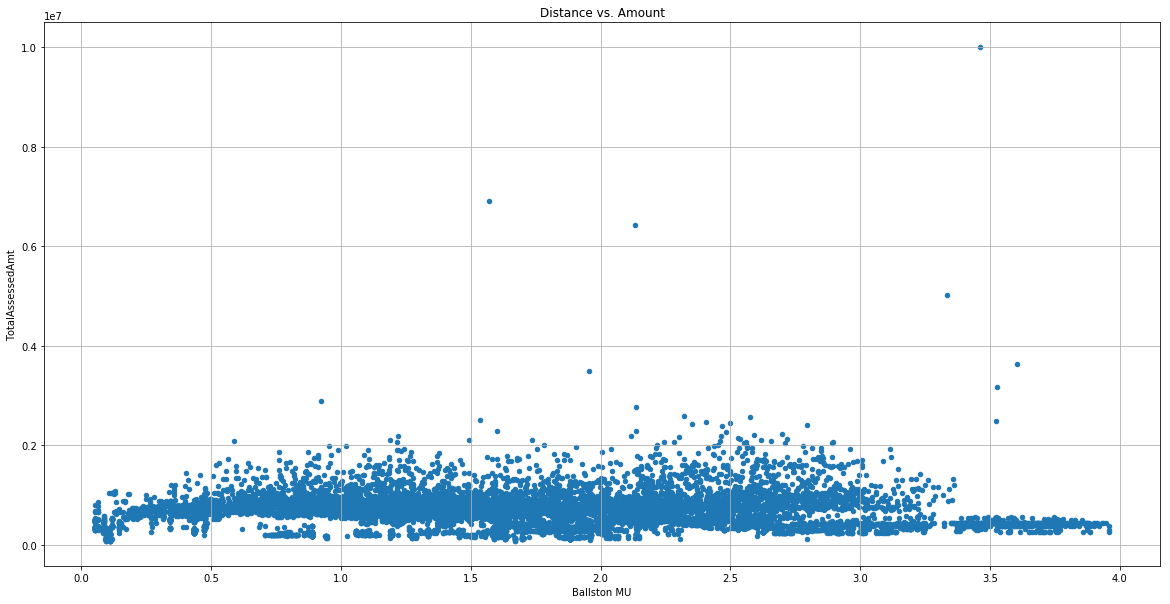

In [17]:
final_house_distMincsv[:]